2024-12-08 13:31:31,523 : INFO : Loading data from ../data/processed/final_sentiment_analysis_data.csv
2024-12-08 13:31:31,610 : INFO : Preparing corpus from pre-processed text...
2024-12-08 13:31:31,625 : INFO : Retained 4966 documents after filtering empty texts
2024-12-08 13:31:31,628 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-12-08 13:31:31,773 : INFO : built Dictionary<20083 unique tokens: ['helps', 'tremendously', 'acceptable', 'add', 'adequate']...> from 4966 documents (total 264920 corpus positions)
2024-12-08 13:31:31,773 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<20083 unique tokens: ['helps', 'tremendously', 'acceptable', 'add', 'adequate']...> from 4966 documents (total 264920 corpus positions)", 'datetime': '2024-12-08T13:31:31.773610', 'gensim': '4.3.3', 'python': '3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) \n[Clang 16.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'created'}
2024-12-08 13:31:

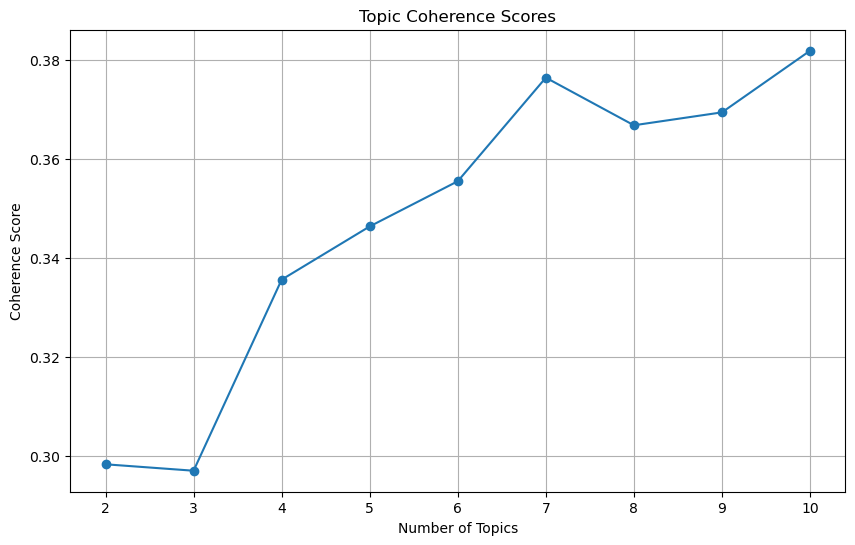

2024-12-08 13:33:48,531 : INFO : Optimal number of topics: 10
2024-12-08 13:33:48,532 : INFO : Building LDA model with 10 topics...
2024-12-08 13:33:48,533 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2024-12-08 13:33:48,534 : INFO : using symmetric eta at 0.1
2024-12-08 13:33:48,535 : INFO : using serial LDA version on this node
2024-12-08 13:33:48,541 : INFO : running online (multi-pass) LDA training, 10 topics, 15 passes over the supplied corpus of 4966 documents, updating model once every 2000 documents, evaluating perplexity every 4966 documents, iterating 50x with a convergence threshold of 0.001000
2024-12-08 13:33:48,544 : INFO : PROGRESS: pass 0, at document #2000/4966
2024-12-08 13:33:49,073 : INFO : optimized alpha [0.091918774, 0.09987174, 0.095449865, 0.09894187, 0.09019931, 0.103779644, 0.09424861, 0.08907682, 0.10503536, 0.08770544]
2024-12-08 13:33:49,074 : INFO : merging changes from 2000 documents into a model of 496


Top words in each topic:

Topic 0:
not (0.015), all (0.010), so (0.009), router (0.009), get (0.007), one (0.006), windows (0.006), just (0.006), would (0.006), wifi (0.006)

Topic 1:
keyboard (0.021), tablet (0.019), screen (0.015), not (0.015), use (0.011), when (0.010), like (0.009), can (0.008), very (0.008), so (0.007)

Topic 2:
tv (0.029), not (0.018), remote (0.009), can (0.008), than (0.008), hdmi (0.008), all (0.008), so (0.008), no (0.007), would (0.007)

Topic 3:
usb (0.035), drive (0.030), card (0.021), power (0.017), gb (0.016), hard (0.011), port (0.010), very (0.009), computer (0.009), fast (0.008)

Topic 4:
case (0.049), ipad (0.021), not (0.014), very (0.013), cover (0.011), like (0.011), when (0.011), well (0.010), screen (0.008), fits (0.008)

Topic 5:
one (0.017), so (0.015), not (0.014), like (0.010), battery (0.009), just (0.009), time (0.009), will (0.008), use (0.008), more (0.008)

Topic 6:
camera (0.049), lens (0.013), can (0.012), video (0.011), not (0.009),

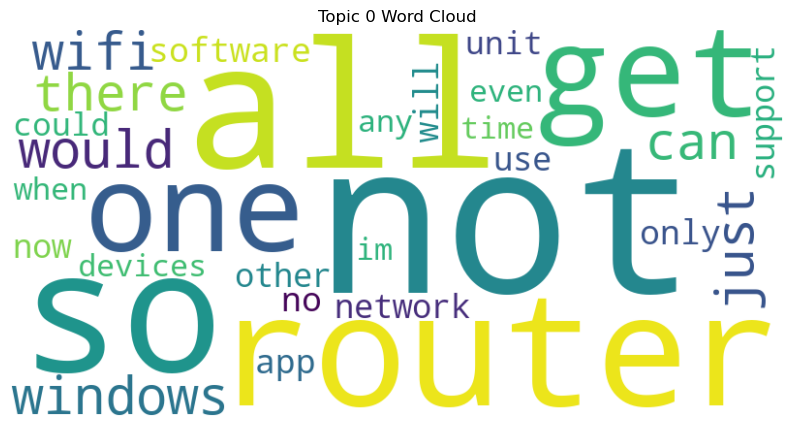

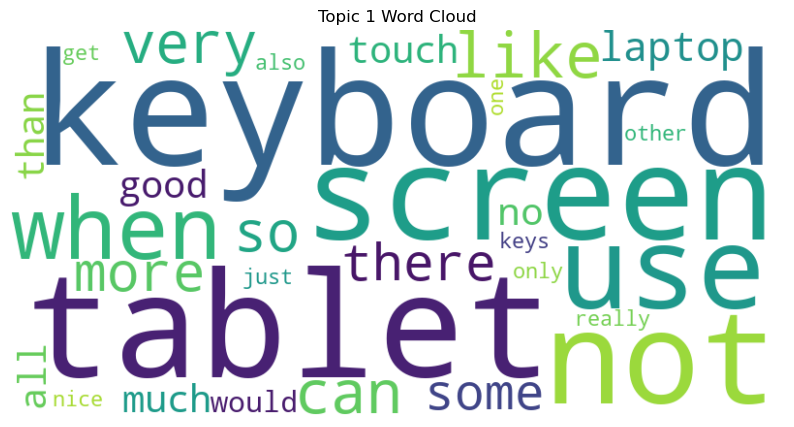

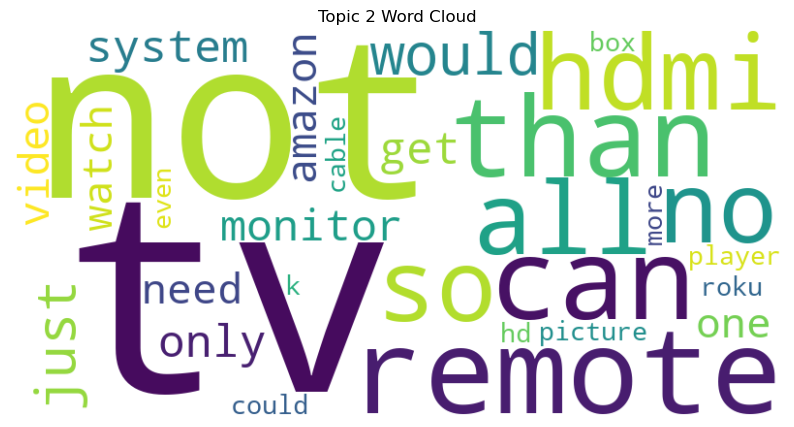

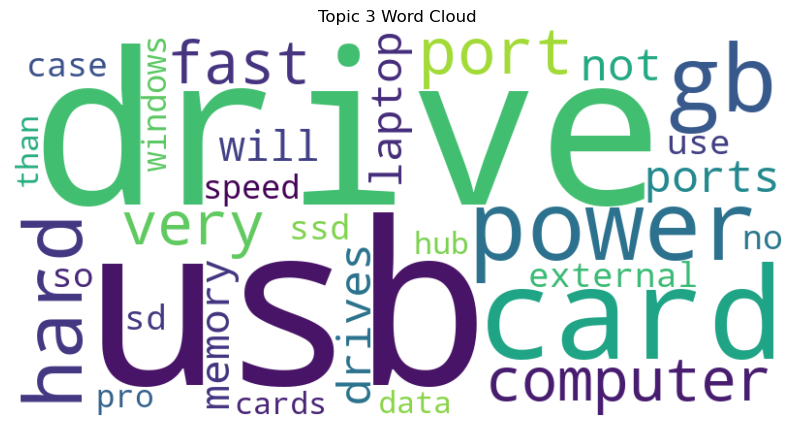

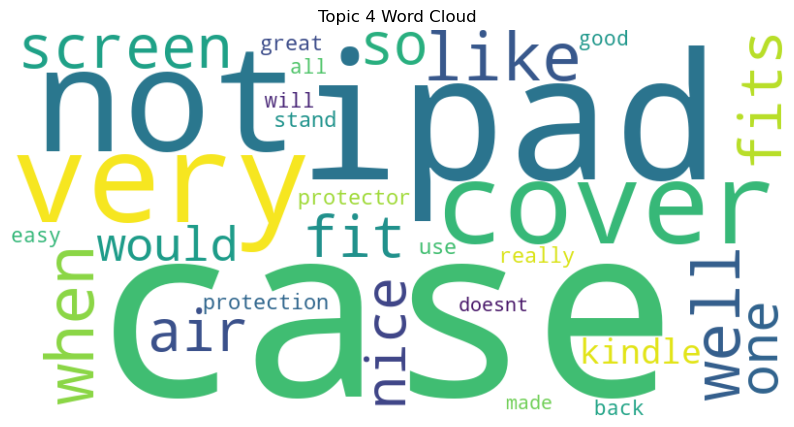

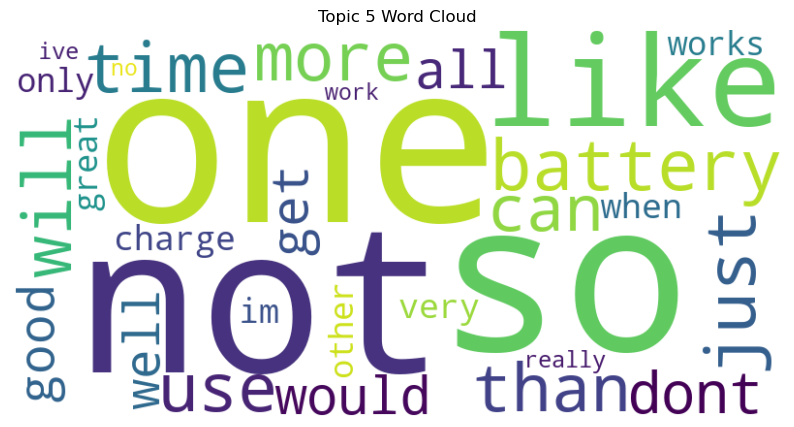

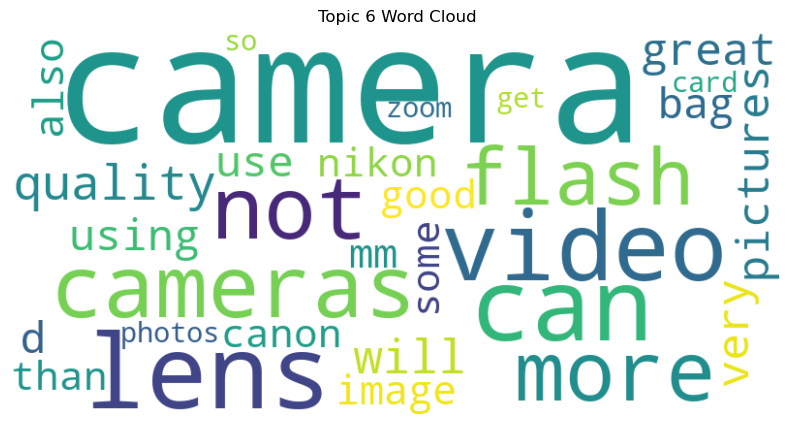

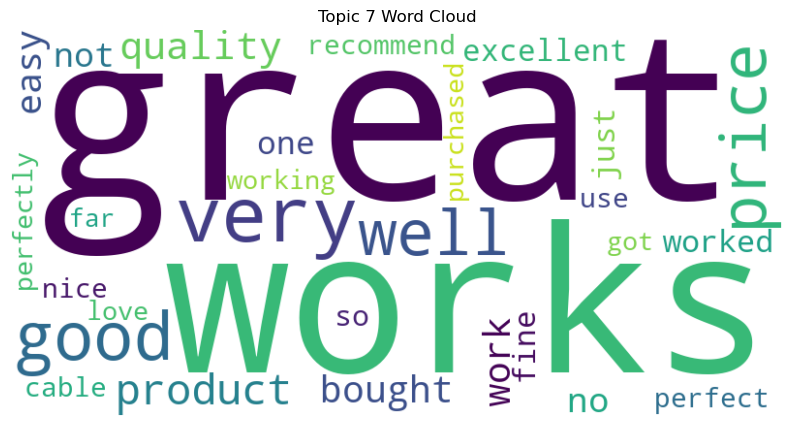

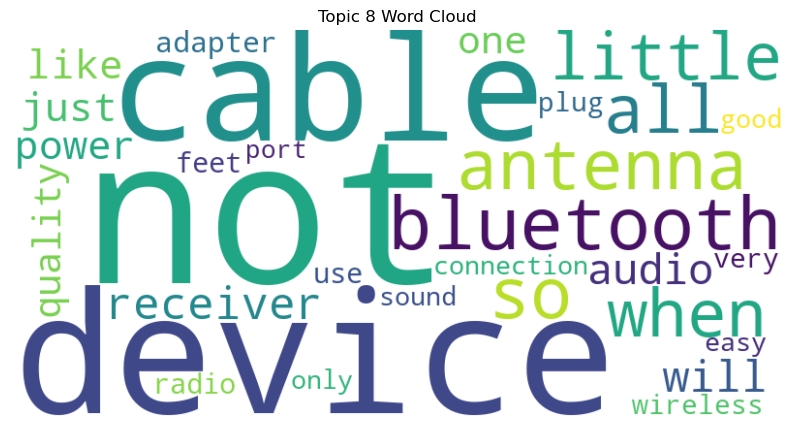

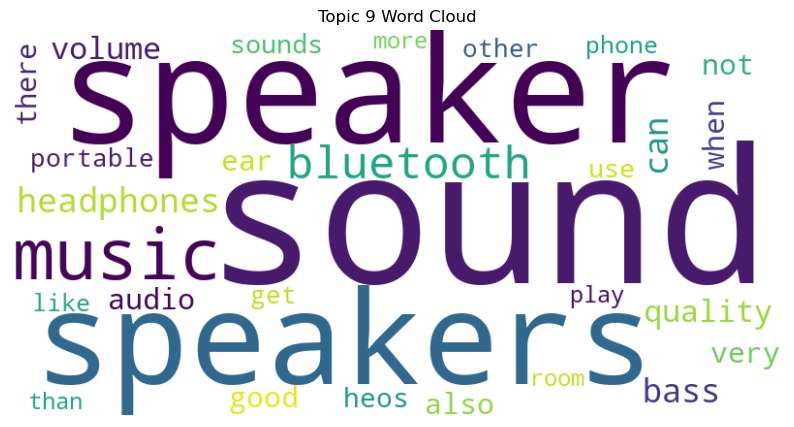

<Figure size 1200x600 with 0 Axes>

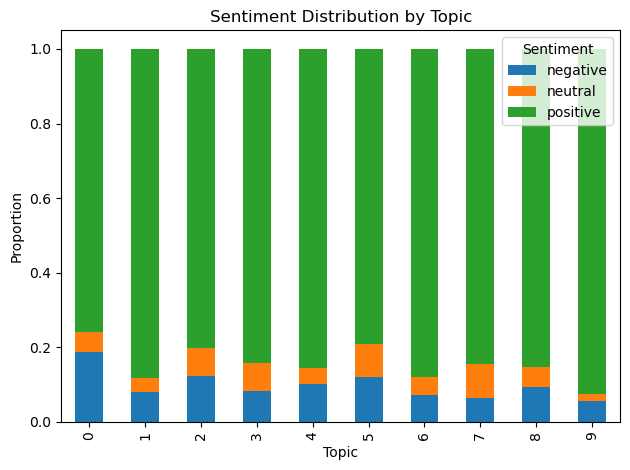


Analysis complete!


In [1]:
import pandas as pd
import numpy as np
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import logging
import os

class TopicSentimentAnalyzer:
    def __init__(self, data_path: str):
        """Initialize the analyzer with the preprocessed data."""
        # Set up logging
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        
        # Load data
        logging.info(f"Loading data from {data_path}")
        self.data = pd.read_csv(data_path)
        self.dictionary = None
        self.corpus = None
        self.lda_model = None
        
    def prepare_corpus(self):
        """Prepare the document corpus for topic modeling using pre-processed text."""
        logging.info("Preparing corpus from pre-processed text...")
        
        # Convert processed_text strings into token lists
        # The processed_text is already tokenized, just need to split it into a list
        self.data['tokens'] = self.data['processed_text'].str.split()
        
        # Remove empty documents
        non_empty_mask = self.data['tokens'].map(len) > 0
        if not non_empty_mask.any():
            raise ValueError("No valid documents after preprocessing!")
            
        logging.info(f"Retained {non_empty_mask.sum()} documents after filtering empty texts")
        self.data = self.data[non_empty_mask].copy()
        
        # Create dictionary and corpus
        self.dictionary = corpora.Dictionary(self.data['tokens'])
        
        # Filter out extremely rare and common words
        self.dictionary.filter_extremes(no_below=5, no_above=0.5)
        
        # Create corpus
        self.corpus = [self.dictionary.doc2bow(tokens) for tokens in self.data['tokens']]
        
        logging.info(f"Created corpus with {len(self.corpus)} documents and {len(self.dictionary)} unique terms")
    
    def find_optimal_topics(self, start: int = 2, end: int = 10, step: int = 1) -> int:
        """Find optimal number of topics using coherence scores."""
        if not self.corpus:
            raise ValueError("Corpus not prepared. Run prepare_corpus() first.")
            
        coherence_scores = []
        topics_range = range(start, end + 1, step)
        
        for num_topics in topics_range:
            logging.info(f"Testing model with {num_topics} topics...")
            lda_model = LdaModel(
                corpus=self.corpus,
                id2word=self.dictionary,
                num_topics=num_topics,
                random_state=42,
                passes=15,
                alpha='auto',
                per_word_topics=True
            )
            
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=self.data['tokens'].tolist(),
                dictionary=self.dictionary,
                coherence='c_v'
            )
            
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append(coherence_score)
            logging.info(f"Coherence score for {num_topics} topics: {coherence_score}")
        
        # Plot coherence scores
        plt.figure(figsize=(10, 6))
        plt.plot(list(topics_range), coherence_scores, marker='o')
        plt.xlabel("Number of Topics")
        plt.ylabel("Coherence Score")
        plt.title("Topic Coherence Scores")
        plt.grid(True)
        plt.show()
        
        optimal_topics = start + coherence_scores.index(max(coherence_scores)) * step
        logging.info(f"Optimal number of topics: {optimal_topics}")
        return optimal_topics
    
    def build_lda_model(self, num_topics: int):
        """Build the LDA model with specified number of topics."""
        logging.info(f"Building LDA model with {num_topics} topics...")
        self.lda_model = LdaModel(
            corpus=self.corpus,
            id2word=self.dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=15,
            alpha='auto',
            per_word_topics=True
        )
    
    def analyze_and_visualize(self):
        """Perform analysis and create visualizations."""
        if not self.lda_model:
            raise ValueError("LDA model not built. Run build_lda_model() first.")
        
        # Get dominant topics
        doc_topics = []
        for doc in self.corpus:
            topic_dist = self.lda_model.get_document_topics(doc)
            dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
            doc_topics.append(dominant_topic)
        
        self.data['dominant_topic'] = doc_topics
        
        # Print topics with their words and weights
        print("\nTop words in each topic:")
        for idx in range(self.lda_model.num_topics):
            topic_words = self.lda_model.show_topic(idx, topn=10)
            print(f"\nTopic {idx}:")
            print(", ".join([f"{word} ({weight:.3f})" for word, weight in topic_words]))
        
        # Create topic word clouds
        for topic_id in range(self.lda_model.num_topics):
            plt.figure(figsize=(10, 6))
            topic_words = dict(self.lda_model.show_topic(topic_id, topn=30))
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white'
            ).generate_from_frequencies(topic_words)
            
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Topic {topic_id} Word Cloud')
            plt.show()
        
        # Calculate and plot sentiment distribution by topic
        sentiment_dist = pd.crosstab(
            self.data['dominant_topic'], 
            self.data['sentiment'], 
            normalize='index'
        )
        
        plt.figure(figsize=(12, 6))
        sentiment_dist.plot(
            kind='bar', 
            stacked=True
        )
        plt.title('Sentiment Distribution by Topic')
        plt.xlabel('Topic')
        plt.ylabel('Proportion')
        plt.legend(title='Sentiment')
        plt.tight_layout()
        plt.show()
        
        return sentiment_dist

def main():
    """Main function to run topic modeling and sentiment analysis."""
    try:
        # Initialize analyzer
        analyzer = TopicSentimentAnalyzer("../data/processed/final_sentiment_analysis_data.csv")
        
        # Prepare data
        analyzer.prepare_corpus()
        
        # Find optimal topics
        optimal_topics = analyzer.find_optimal_topics(start=2, end=10, step=1)
        
        # Build and analyze model
        analyzer.build_lda_model(optimal_topics)
        results = analyzer.analyze_and_visualize()
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Original Distribution:
sentiment
positive    4131
negative     505
neutral      330
Name: count, dtype: int64

Original Percentages:
sentiment
positive    83.2
negative    10.2
neutral      6.6
Name: proportion, dtype: float64

Using sample size of 330 (size of smallest class)

Balanced Distribution:
sentiment
positive    330
negative    330
neutral     330
Name: count, dtype: int64

Balanced Percentages:
sentiment
positive    33.3
negative    33.3
neutral     33.3
Name: proportion, dtype: float64


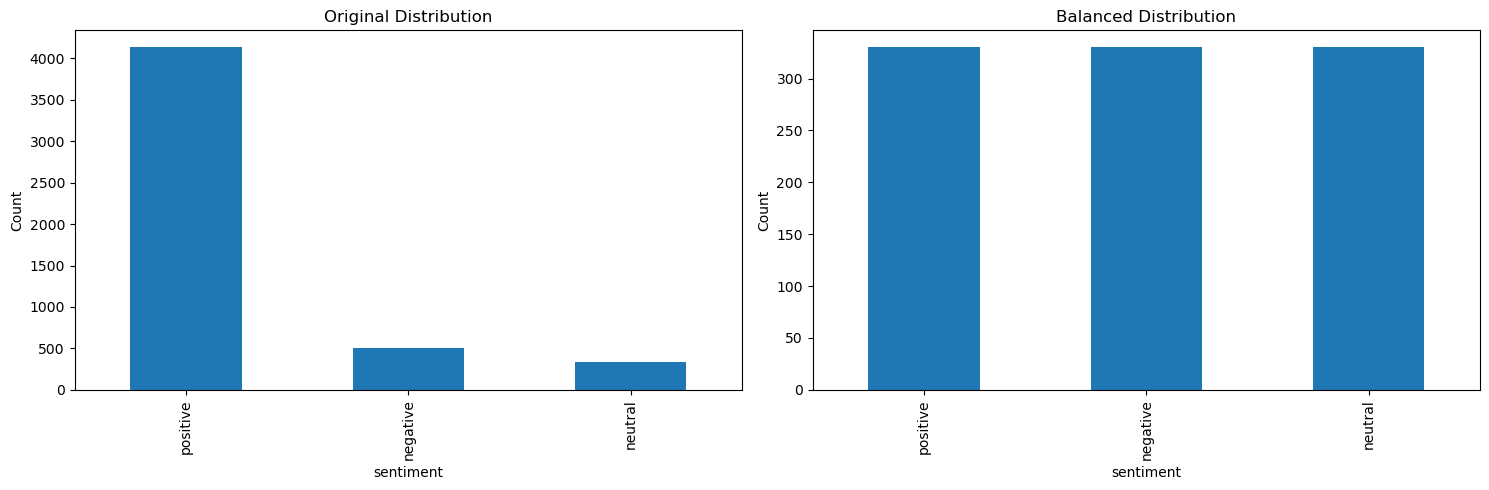

2024-12-08 14:25:43,763 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-12-08 14:25:43,797 : INFO : built Dictionary<6824 unique tokens: ['accurate', 'actually', 'allows', 'also', 'better']...> from 990 documents (total 40067 corpus positions)
2024-12-08 14:25:43,798 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<6824 unique tokens: ['accurate', 'actually', 'allows', 'also', 'better']...> from 990 documents (total 40067 corpus positions)", 'datetime': '2024-12-08T14:25:43.798042', 'gensim': '4.3.3', 'python': '3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) \n[Clang 16.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'created'}
2024-12-08 14:25:43,801 : INFO : discarding 5513 tokens: [('luckily', 1), ('pens', 1), ('precision', 1), ('tapping', 1), ('tip', 3), ('weighttip', 1), ('amps', 3), ('compares', 1), ('designstrongly', 1), ('detects', 2)]...
2024-12-08 14:25:43,801 : INFO : keeping 1311 tokens which were in no less th


Dataset sizes:
Original dataset: 4966 reviews
Balanced dataset: 990 reviews


2024-12-08 14:25:43,818 : INFO : using serial LDA version on this node
2024-12-08 14:25:43,820 : INFO : running online (multi-pass) LDA training, 7 topics, 15 passes over the supplied corpus of 990 documents, updating model once every 990 documents, evaluating perplexity every 990 documents, iterating 50x with a convergence threshold of 0.001000
2024-12-08 14:25:44,021 : INFO : -8.088 per-word bound, 272.1 perplexity estimate based on a held-out corpus of 990 documents with 30879 words
2024-12-08 14:25:44,021 : INFO : PROGRESS: pass 0, at document #990/990
2024-12-08 14:25:44,182 : INFO : optimized alpha [0.13351214, 0.12951061, 0.13141601, 0.1233573, 0.11995636, 0.12861031, 0.119359806]
2024-12-08 14:25:44,184 : INFO : topic #6 (0.119): 0.014*"not" + 0.014*"very" + 0.009*"so" + 0.008*"back" + 0.008*"all" + 0.008*"use" + 0.007*"when" + 0.007*"can" + 0.007*"no" + 0.007*"get"
2024-12-08 14:25:44,184 : INFO : topic #4 (0.120): 0.014*"one" + 0.013*"not" + 0.012*"case" + 0.010*"so" + 0.010*

<Figure size 1200x600 with 0 Axes>

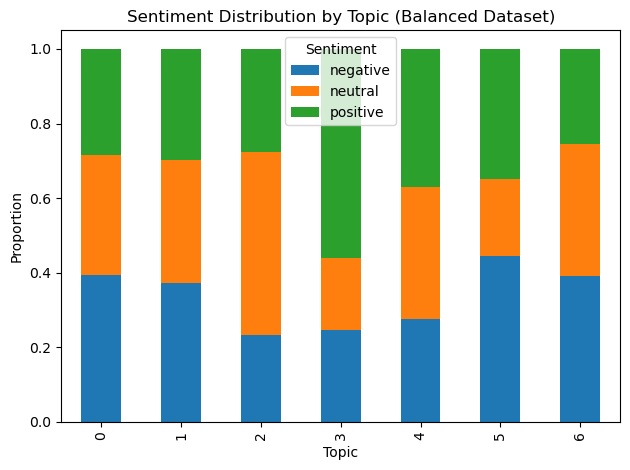

2024-12-08 14:25:47,632 : INFO : topic #0 (0.070): 0.030*"not" + 0.010*"will" + 0.010*"use" + 0.009*"when" + 0.009*"so" + 0.009*"than" + 0.009*"very" + 0.008*"would" + 0.008*"more" + 0.007*"drive"
2024-12-08 14:25:47,633 : INFO : topic #1 (0.068): 0.023*"not" + 0.015*"one" + 0.013*"use" + 0.012*"keyboard" + 0.012*"would" + 0.009*"kindle" + 0.008*"no" + 0.008*"product" + 0.008*"so" + 0.008*"time"
2024-12-08 14:25:47,633 : INFO : topic #2 (0.071): 0.018*"works" + 0.017*"so" + 0.016*"not" + 0.015*"no" + 0.013*"can" + 0.010*"really" + 0.010*"work" + 0.009*"very" + 0.009*"well" + 0.009*"use"
2024-12-08 14:25:47,634 : INFO : topic #3 (0.061): 0.025*"sound" + 0.017*"speaker" + 0.014*"not" + 0.013*"good" + 0.012*"great" + 0.012*"one" + 0.011*"speakers" + 0.011*"very" + 0.010*"can" + 0.010*"music"
2024-12-08 14:25:47,634 : INFO : topic #4 (0.058): 0.022*"case" + 0.019*"one" + 0.015*"great" + 0.014*"cable" + 0.013*"will" + 0.012*"ipad" + 0.011*"not" + 0.010*"use" + 0.010*"works" + 0.010*"quality


Top words in each topic:

Topic 0:
(0, '0.030*"not" + 0.010*"will" + 0.010*"use" + 0.009*"when" + 0.009*"so" + 0.009*"than" + 0.009*"very" + 0.008*"would" + 0.008*"more" + 0.007*"drive"')

Topic 1:
(1, '0.023*"not" + 0.015*"one" + 0.013*"use" + 0.012*"keyboard" + 0.012*"would" + 0.009*"kindle" + 0.008*"no" + 0.008*"product" + 0.008*"so" + 0.008*"time"')

Topic 2:
(2, '0.018*"works" + 0.017*"so" + 0.016*"not" + 0.015*"no" + 0.013*"can" + 0.010*"really" + 0.010*"work" + 0.009*"very" + 0.009*"well" + 0.009*"use"')

Topic 3:
(3, '0.025*"sound" + 0.017*"speaker" + 0.014*"not" + 0.013*"good" + 0.012*"great" + 0.012*"one" + 0.011*"speakers" + 0.011*"very" + 0.010*"can" + 0.010*"music"')

Topic 4:
(4, '0.022*"case" + 0.019*"one" + 0.015*"great" + 0.014*"cable" + 0.013*"will" + 0.012*"ipad" + 0.011*"not" + 0.010*"use" + 0.010*"works" + 0.010*"quality"')

Topic 5:
(5, '0.016*"not" + 0.012*"so" + 0.012*"all" + 0.011*"one" + 0.009*"usb" + 0.009*"other" + 0.007*"no" + 0.007*"when" + 0.007*"just" +

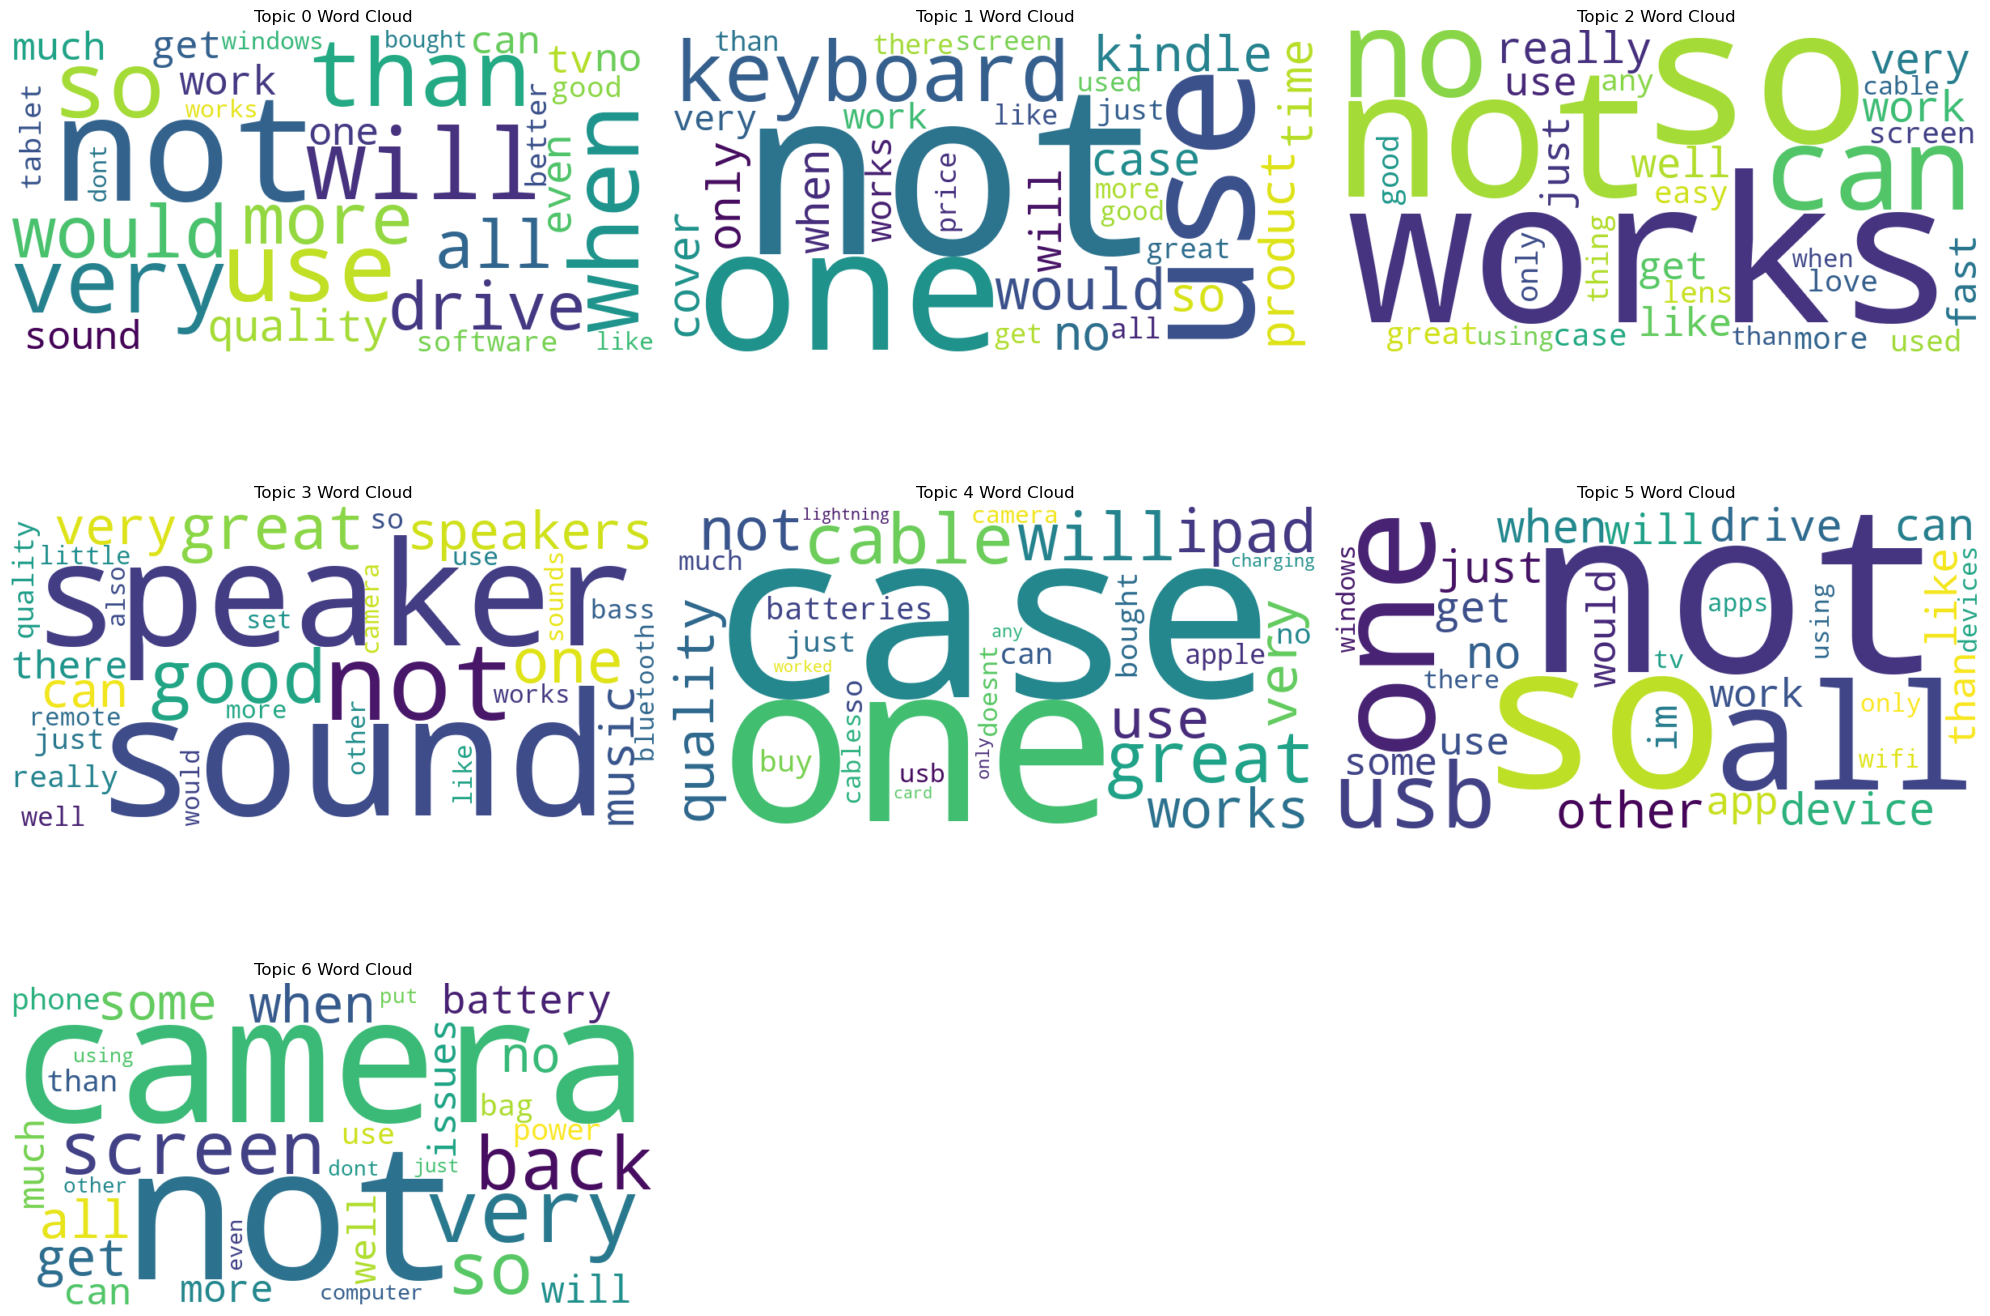


Analyzing topics with high negative sentiment...
Topics Ranked by Negative Sentiment Proportion:
dominant_topic
5    0.443548
0    0.400000
6    0.393162
1    0.376712
4    0.276923
3    0.243697
2    0.231959
Name: negative, dtype: float64

Detailed Analysis of Most Negative Topics:

Topic 5:
Top Words:
  - not: 0.016
  - so: 0.012
  - all: 0.012
  - one: 0.011
  - usb: 0.009
  - other: 0.009
  - no: 0.007
  - when: 0.007
  - just: 0.007
  - can: 0.007

Example Negative Reviews:
  1. These fans are quiet on all but the highest speeds, they don't rattle around no matter how you mount them, and they push some serious air. What's not to love?...
  2. The unit after three days of files transfer with the USB switch connected to it lost it's power and connectivity. I can not access it or retrieve the files (when the lights came on sporadically. I wil...
  3. No problems yet. Can't make adjustments when in other modes so that's a bit frustrating....

Topic 0:
Top Words:
  - not: 0.030
  - w

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set up logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def create_balanced_dataset(data, target_column='sentiment', random_state=42):
    """
    Create a balanced dataset using undersampling, adjusting for the smallest class size.
    
    Args:
        data (pd.DataFrame): Original imbalanced dataset
        target_column (str): Name of the sentiment column
        random_state (int): Random seed for reproducibility
        
    Returns:
        pd.DataFrame: Balanced dataset
    """
    # Print original distribution
    print("Original Distribution:")
    original_dist = data[target_column].value_counts()
    print(original_dist)
    print("\nOriginal Percentages:")
    print(data[target_column].value_counts(normalize=True).multiply(100).round(1))
    
    # Separate by sentiment
    positive = data[data[target_column] == 'positive']
    negative = data[data[target_column] == 'negative']
    neutral = data[data[target_column] == 'neutral']
    
    # Get the size of the smallest class
    min_size = min(len(positive), len(negative), len(neutral))
    print(f"\nUsing sample size of {min_size} (size of smallest class)")
    
    # Undersample all classes to the size of the smallest class
    positive_downsampled = resample(positive,
                                  replace=False,
                                  n_samples=min_size,
                                  random_state=random_state)
    
    negative_downsampled = resample(negative,
                                  replace=False,
                                  n_samples=min_size,
                                  random_state=random_state)
    
    neutral_downsampled = resample(neutral,
                                 replace=False,
                                 n_samples=min_size,
                                 random_state=random_state)
    
    # Combine all the samples
    balanced_data = pd.concat([
        positive_downsampled, 
        negative_downsampled, 
        neutral_downsampled
    ])
    
    # Print new distribution
    print("\nBalanced Distribution:")
    balanced_dist = balanced_data[target_column].value_counts()
    print(balanced_dist)
    print("\nBalanced Percentages:")
    print(balanced_data[target_column].value_counts(normalize=True).multiply(100).round(1))
    
    # Plot the distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    original_dist.plot(kind='bar', ax=ax1, title='Original Distribution')
    ax1.set_ylabel('Count')
    
    # Balanced distribution
    balanced_dist.plot(kind='bar', ax=ax2, title='Balanced Distribution')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return balanced_data

def prepare_corpus(data, text_column='processed_text'):
    """
    Prepare the document corpus for topic modeling.
    
    Args:
        data (pd.DataFrame): Input dataframe
        text_column (str): Name of the text column
        
    Returns:
        tuple: (dictionary, corpus, token_lists)
    """
    # Convert processed_text strings into token lists
    token_lists = data[text_column].str.split()
    
    # Create dictionary
    dictionary = corpora.Dictionary(token_lists)
    
    # Filter extreme words
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    
    # Create corpus
    corpus = [dictionary.doc2bow(tokens) for tokens in token_lists]
    
    return dictionary, corpus, token_lists

def run_topic_modeling(dictionary, corpus, token_lists, num_topics=7):
    """
    Run LDA topic modeling.
    
    Args:
        dictionary: Gensim dictionary
        corpus: Document corpus
        token_lists: List of tokenized documents
        num_topics (int): Number of topics to model
        
    Returns:
        LdaModel: Trained LDA model
    """
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=15,
        alpha='auto',
        per_word_topics=True
    )
    
    return lda_model

def analyze_sentiment_distribution(data, lda_model, corpus):
    """
    Analyze sentiment distribution across topics.
    
    Args:
        data (pd.DataFrame): Input dataframe with sentiment labels
        lda_model: Trained LDA model
        corpus: Document corpus
        
    Returns:
        pd.DataFrame: Sentiment distribution by topic
    """
    # Get dominant topic for each document
    doc_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        doc_topics.append(dominant_topic)
    
    # Add dominant topic to dataframe
    data['dominant_topic'] = doc_topics
    
    # Calculate sentiment distribution
    sentiment_dist = pd.crosstab(
        data['dominant_topic'],
        data['sentiment'],
        normalize='index'
    )
    
    # Plot sentiment distribution
    plt.figure(figsize=(12, 6))
    sentiment_dist.plot(kind='bar', stacked=True)
    plt.title('Sentiment Distribution by Topic (Balanced Dataset)')
    plt.xlabel('Topic')
    plt.ylabel('Proportion')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
    return sentiment_dist

def generate_topic_wordclouds(lda_model, num_words=30):
    """
    Generate and display word clouds for each topic.
    
    Args:
        lda_model: Trained LDA model
        num_words: Number of top words to include
    """
    plt.figure(figsize=(20, 15))
    cols = 3
    rows = (lda_model.num_topics + cols - 1) // cols
    
    for topic_id in range(lda_model.num_topics):
        topic_words = dict(lda_model.show_topic(topic_id, topn=num_words))
        
        # Create word cloud
        plt.subplot(rows, cols, topic_id + 1)
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white'
        ).generate_from_frequencies(topic_words)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_id} Word Cloud')
    
    plt.tight_layout()
    plt.show()

def analyze_negative_sentiment_topics(data, lda_model, corpus):
    """
    Analyze topics with higher negative sentiment.
    
    Args:
        data: DataFrame with sentiment and topic assignments
        lda_model: Trained LDA model
        corpus: Document corpus
    """
    # Get dominant topic for each document
    doc_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        doc_topics.append(dominant_topic)
    
    data['dominant_topic'] = doc_topics
    
    # Calculate sentiment distribution by topic
    sentiment_dist = pd.crosstab(
        data['dominant_topic'],
        data['sentiment'],
        normalize='index'
    )
    
    # Sort topics by negative sentiment proportion
    topics_by_negative = sentiment_dist['negative'].sort_values(ascending=False)
    
    print("Topics Ranked by Negative Sentiment Proportion:")
    print(topics_by_negative)
    
    # Analyze top 3 most negative topics
    top_negative_topics = topics_by_negative.head(3).index
    
    print("\nDetailed Analysis of Most Negative Topics:")
    for topic_id in top_negative_topics:
        print(f"\nTopic {topic_id}:")
        print("Top Words:")
        for word, prob in lda_model.show_topic(topic_id, topn=10):
            print(f"  - {word}: {prob:.3f}")
            
        # Get example negative reviews for this topic
        topic_negative_reviews = data[
            (data['dominant_topic'] == topic_id) & 
            (data['sentiment'] == 'negative')
        ]['review_text'].head(3)
        
        print("\nExample Negative Reviews:")
        for i, review in enumerate(topic_negative_reviews, 1):
            print(f"  {i}. {review[:200]}...")

def main():
    """
    Main function to run the balanced topic modeling analysis.
    """
    try:
        # Load data
        data = pd.read_csv("../data/processed/final_sentiment_analysis_data.csv")
        
        # Create balanced dataset
        balanced_data = create_balanced_dataset(data)
        
        # Print dataset sizes
        print("\nDataset sizes:")
        print(f"Original dataset: {len(data)} reviews")
        print(f"Balanced dataset: {len(balanced_data)} reviews")
        
        # Prepare corpus
        dictionary, corpus, token_lists = prepare_corpus(balanced_data)
        
        # Run topic modeling
        lda_model = run_topic_modeling(dictionary, corpus, token_lists)
        
        # Analyze sentiment distribution
        sentiment_dist = analyze_sentiment_distribution(balanced_data, lda_model, corpus)
        
        # Print topics
        print("\nTop words in each topic:")
        for idx, topic in enumerate(lda_model.print_topics()):
            print(f"\nTopic {idx}:")
            print(topic)

        # Generate word clouds
        print("Generating word clouds for balanced dataset topics...")
        generate_topic_wordclouds(lda_model)
        
        # Analyze negative sentiment topics
        print("\nAnalyzing topics with high negative sentiment...")
        analyze_negative_sentiment_topics(balanced_data, lda_model, corpus)
        
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()